In [1]:
## Warning!  Do not run this unless 2018 CCAR has been run! (Otherwise, it will cause error.)
##   Note: you can always alter the list of CCAR years to analyze by altering the "ccyr" variable when it is defined below.
import numpy as np
import pandas as pd
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt

import os
os.chdir('C:/BankRisk')

In [2]:
grp = 'FailRt'

#rtyp = "1q" # "1q" indicates quarterly fail rates (standard)
rtyp = "4q" # "4q" indicates rolling 4q fail rates (standard)

test = "_cboD"  ## denotes combo designation
vlst = ['Orig','Lags','Lags_sUE2']
#cbo = ['Orig','Lags','Lags_sUE2'] # combo tags (for use in charts)

if rtyp == "4q":
  rclst = ['FailRt4q']
  rskp = 3
elif rtyp == "1q":
  rclst = ['FailRt']
  rskp = 0
else:
  rclst = []
  rskp = 999  # force error if no specification

vofi = "FailRates_all2.csv"             ## history volumes file for groups to analyze
vo_orig = pd.read_csv(vofi, index_col=0, parse_dates=True)
vo_orig = vo_orig.astype(float)

nmlst = ['CBfail']
dmlst = ['CBnbr']

nmz = dict(zip(rclst, nmlst))
dmz = dict(zip(rclst, dmlst))

#col names to use:
fv = "Fv"  # Fitted model volumes
bv = "Bv"  # Base scenario volumes
av = "Av"  # Adverse scenario volumes
sv = "Sv"  # SevAdv scenario volumes
fm = "Fit"  # these last 4 are model outputs for fitted model & 3 scenarios
bm = "Base"
am = "Adverse"
sm = "SevAdv"

dfz1 = []
dfz3 = []

In [3]:
vo_orig.tail()

CBfail   CBnbr    FailRt  FailRt4q
Date                                          
2017-06-30     3.0  5011.0  0.239473  0.157217
2017-09-30     0.0  4969.0  0.000000  0.119089
2017-12-31     2.0  4918.0  0.162668  0.160337
2018-03-31     0.0  4880.0  0.000000  0.101122
2018-06-30     0.0  4833.0  0.000000  0.040816

In [4]:
balst= []
dmlst = []

In [5]:
## caution:  be sure that all ccar years have been modeled using br002c... module
##  if 2018 CCAR has not been run using br002c... series, then do not include 2018 in this list (error will result)
#ccyr = [2012,2013,2014,2015]  # this list was used in the book
ccyr = [2012,2013,2014,2015,2016,2017,2018]

In [6]:
for yr in ccyr:
  if yr <= 2015:
    dttr = str(yr-1) + "-09-30"  # transition date (3rd qtr of year prior to CCAR year)
    dtst = str(yr-1) + "-12-31"  # start of 9q forecast period
    dten = str(yr+1) + "-12-31"  # end of 9q forecast period
  else:
    dttr = str(yr-1) + "-12-31"  # transition date (3rd qtr of year prior to CCAR year)
    dtst = str(yr) + "-03-31"  # start of 9q forecast period
    dten = str(yr+2) + "-03-31"  # end of 9q forecast period
    
  if yr >= 2016: 
    vo = vo_orig.ix[:dttr]  # special handling for CCAR years after 2015
  else:
    vo = vo_orig.ix[:"2014-12-31"]  # conforms to book exhibits

  for mn in [1,3]:
    if mn == 1:
      mtyp = '_full'
    elif mn == 3:
      mtyp = '_3v'
    
    for suff in vlst:
    
      hdrw = [0,1] # indicates first 2 rows in forecast file "rtfi" have col headings
    
      rtfi = grp + "_" + str(yr) + mtyp + "_fcst_" + rtyp + '_' + suff + test + ".csv" ## file with modeled ccar forecast nco/fail rates
      rt = pd.read_csv(rtfi, index_col=0, header=hdrw, parse_dates=True)
      paramfi = grp + "_" + str(yr) + mtyp + "_param_" + rtyp + '_' + suff + test + ".csv"  ## param file for same run
    
      param = pd.read_csv(paramfi, index_col=0, header=0)
      param.index.name= 'scen'
    
      ### start prod loops here:
      balst= []
      dmlst = []
    
      for pr in np.arange(len(rt.columns.levels[0])):
        #pr = 2 # prod indexer
    
        drt = rt[rt.columns.levels[0][pr]]
        drt.reset_index(drop=False, inplace=True)
        drt.set_index('Date', inplace=True)
    
        if mn == 3:  ## 3var model
          prn = rt.columns.levels[0][pr][0:-1]
        else:        ## full model
          prn = rt.columns.levels[0][pr]
    
        df = vo[[nmz[prn],dmz[prn]]]
        df.columns = ['nco','bal']
        df.index.name = 'Date'
        df.reset_index(drop=False, inplace=True)
        df.set_index('Date',inplace=True)
    
        dfr = df.merge(drt, how='outer', left_index=True, right_index=True)
    
        # seed early rows of vol cols with actuals, then calc model vols for forecast periods:
        dfr['Bv'] = dfr['nco']
        dfr['Av'] = dfr['nco']
        dfr['Sv'] = dfr['nco']
    
        dfr['bal'] = dfr['bal'].fillna(method='pad')
        dfr[[bm,am,sm]] = dfr[[bm,am,sm]].fillna(-999)
    
        dfr.ix[dttr][bm] = -999
        for x in np.arange(len(dfr))[rskp:]:
          if dfr.ix[x][bm] == -999:
            dfr.ix[x][bv] = dfr.ix[x].nco
          else:
            if rtyp == "4q":
              dfr.ix[x][bv] = dfr.ix[x][bm] * (dfr.ix[x].bal+dfr.ix[x-1].bal+dfr.ix[x-2].bal+dfr.ix[x-3].bal)/400 -\
                (dfr.ix[x-1][bv] +dfr.ix[x-2][bv] +dfr.ix[x-3][bv])
            else:
              dfr.ix[x][bv] = dfr.ix[x][bm] * dfr.ix[x].bal/400 
    
        dfr.ix[dttr][am] = -999
        for x in np.arange(len(dfr))[rskp:]:
          if dfr.ix[x][am] == -999:
            dfr.ix[x][av] = dfr.ix[x].nco
          else:
            if rtyp == "4q":
              dfr.ix[x][av] = dfr.ix[x][am] * (dfr.ix[x].bal+dfr.ix[x-1].bal+dfr.ix[x-2].bal+dfr.ix[x-3].bal)/400 -\
                (dfr.ix[x-1][av] +dfr.ix[x-2][av] +dfr.ix[x-3][av])
            else:
              dfr.ix[x][av] = dfr.ix[x][am] * dfr.ix[x].bal/400 
    
        dfr.ix[dttr][sm] = -999
        for x in np.arange(len(dfr))[rskp:]:
          if dfr.ix[x][sm] == -999:
            dfr.ix[x][sv] = dfr.ix[x].nco
          else:
            if rtyp == "4q":
              dfr.ix[x][sv] = dfr.ix[x][sm] * (dfr.ix[x].bal+dfr.ix[x-1].bal+dfr.ix[x-2].bal+dfr.ix[x-3].bal)/400 -\
                (dfr.ix[x-1][sv] +dfr.ix[x-2][sv] +dfr.ix[x-3][sv])
            else:
              dfr.ix[x][sv] = dfr.ix[x][sm] * dfr.ix[x].bal/400 
    
        ## NEW SECTION:
        dfr.replace(to_replace=-999, value=np.nan, inplace=True)  ## replace -999 with nan
        for i in np.arange(len(dfr)):     ## remove forecast Adverse vol if there is no Adverse scenario
          if dfr.iloc[i].name >= pd.to_datetime(dtst):  ## check that this is a forecast period, not history
            if np.isnan(dfr.ix[i]['Adverse']):
              dfr.ix[i]['Av'] = np.nan
    
        dfv = dfr[['Bv','Av','Sv']].ix[dtst:dten].sum()  # 9q forecasts (ignore nco, Fv)
    
        r9q = dfr['2006-12-31':dtst]['nco'].rolling(9, min_periods=9).sum()
        r9q = r9q.dropna()
        r9qm = r9q[r9q==r9q.max()]  # largest 9q losses in history
    
        dfv2 = pd.DataFrame(dfv, columns=[rt.columns.levels[0][pr]])
        dfv2.ix['ActMx'] = r9qm.values[0]
        dfv2.ix['DateMx'] = r9qm.index[0]
        dfv2t = dfv2.T
        dfv2t.reset_index(drop=False, inplace=True)
    
        b9q = dfr['2006-12-31':dtst]['bal'].rolling(9, min_periods=9).mean()
        balst = balst + [b9q.ix[r9qm.index[0]]]  ## avg bal for max actual charge-offs
    
        dmlst = dmlst + [dfr['bal'].ix[dtst:dten].mean()]  ## avg bal during CCAR periods
        voldet = dfr.ix[str(yr-1)+'-01-01':]
        voldet.columns = pd.MultiIndex.from_product([[rt.columns.levels[0][pr]], list(voldet.columns)])
    
        if pr == 0:
          dfvr = dfv2t
          voldet2 = voldet.copy()
        else:
          dfvr = pd.concat([dfvr, dfv2t],ignore_index=True)
          voldet2 = voldet2.merge(voldet, how='left', left_index=True, right_index=True)
    
      if mn == 3:
        dfvr2 = dfvr.copy()
        dfvr2['bal'] = dmlst
        dfvr2['ActBalMx'] = balst
        dfvr2['rk']  = dfvr2.index % mn
        dfvr2['rk'] += 1
    
        dfvr2t = dfvr2.copy()
        dfvr2t['ActMxRt'] = dfvr2t['ActMx']*100/dfvr2t['ActBalMx']
        dfvr2t['ModRt'] = dfvr2t['Sv']*100/dfvr2t['bal']
        dfvr2t['rsq'] = param['r3']
        dfvr2t['Diff'] = dfvr2t['Sv'] - dfvr2t['Bv']
        dfvr2t['Desc'] = param['v1']+','+param['v2']+','+param['v3']+','+grp+"_"+str(yr) + mtyp + "_" + rtyp + suff+test
        dfvr2t = dfvr2t[['index', 'bal', 'Bv', 'Av', 'Sv', 'ActMx', 'ActBalMx', 'DateMx', 'ActMxRt', 'ModRt','rsq', 'Diff', 'Desc']]
        dfvr2t.to_csv(grp + "_" + str(yr) + mtyp + "_" + rtyp + '_' + suff + test + "_vol.csv")
        voldet2.to_csv(grp + "_" + str(yr) + mtyp + "_" + rtyp + '_' + suff + test + "_voldet.csv")
        if suff == vlst[0]:
          dfz3 = dfvr2t.copy()
        else:
          dfz3 = pd.concat([dfz3,dfvr2t], ignore_index=True)
    
      if mn == 1:
        dfvr['bal'] = dmlst
        dfvr['ActBalMx'] = balst
        dfvr[['Bv','Av','Sv','ActMx']] = dfvr[['Bv','Av','Sv','ActMx']].astype(float)
    
        dfvrt = dfvr.copy()
        dfvrt['ActMxRt'] = dfvrt['ActMx']*100/dfvrt['ActBalMx']
        dfvrt['ModRt'] = dfvrt['Sv']*100/dfvrt['bal']
        dfvrt['rsq'] = param.ix['rsq_adj'].values
        dfvrt['Diff'] = dfvrt['Sv'] - dfvrt['Bv']
        dfvrt['Desc'] = grp+"_"+str(yr) + mtyp + "_" + rtyp + suff + test
        dfvrt = dfvrt[['index', 'bal', 'Bv', 'Av', 'Sv', 'ActMx', 'ActBalMx', 'DateMx', 'ActMxRt', 'ModRt','rsq', 'Diff', 'Desc']]
        dfvrt.to_csv(grp + "_" + str(yr) + mtyp + "_" + rtyp + '_' + suff + test + "_vol.csv")
        voldet.to_csv(grp + "_" + str(yr) + mtyp + "_" + rtyp + '_' + suff + test + "_voldet.csv")
        if suff == vlst[0]:
          dfz1 = dfvrt.copy()
        else:
          dfz1 = pd.concat([dfz1,dfvrt],ignore_index=True)
    
      if mn == 3:
        if yr == 2012:
          df3_12 = dfz3.copy()
        elif yr == 2013:
          df3_13 = dfz3.copy()
        elif yr == 2014:
          df3_14 = dfz3.copy()
        elif yr == 2015:
          df3_15 = dfz3.copy()
        elif yr == 2016:
          df3_16 = dfz3.copy()
        elif yr == 2017:
          df3_17 = dfz3.copy()
        elif yr == 2018:
          df3_18 = dfz3.copy()

      if mn == 1:
        if yr == 2012:
          df1_12 = dfz1.copy()
        elif yr == 2013:
          df1_13 = dfz1.copy()
        elif yr == 2014:
          df1_14 = dfz1.copy()
        elif yr == 2015:
          df1_15 = dfz1.copy()
        elif yr == 2016:
          df1_16 = dfz1.copy()
        elif yr == 2017:
          df1_17 = dfz1.copy()
        elif yr == 2018:
          df1_18 = dfz1.copy()



In [7]:
df3_15.tail(2)

index     bal        Bv       Av       Sv ActMx     ActBalMx  \
7  FailRt4q1  5642.0  -19.6067  120.788  219.537   282  6705.333333   
8  FailRt4q2  5642.0 -0.633077  48.0693  212.339   282  6705.333333   

                DateMx  ActMxRt    ModRt       rsq     Diff  \
7  2011-03-31 00:00:00  4.20561  3.89112  0.948973  239.144   
8  2011-03-31 00:00:00  4.20561  3.76354  0.943048  212.972   

                                              Desc  
7  sUE2,Prime,UE_4,FailRt_2015_3v_4qLags_sUE2_cboD  
8      sUE2,UE,BBB,FailRt_2015_3v_4qLags_sUE2_cboD

In [8]:
## stop until all years completed

In [9]:
df1t = pd.concat([df1_12, df1_13, df1_14, df1_15], ignore_index=True)
df3t = pd.concat([df3_12, df3_13, df3_14, df3_15], ignore_index=True)
dfzt = pd.concat([df1_12,df3_12,df1_13,df3_13,df1_14,df3_14,df1_15,df3_15], ignore_index=True)

# append 2016 if available:
if ccyr[-1] >= 2016:
  df1t = pd.concat([df1t, df1_16], ignore_index=True)
  df3t = pd.concat([df3t, df3_16], ignore_index=True)
  dfzt = pd.concat([dfzt, df1_16,df3_16], ignore_index=True)

# append 2017 if available:
if ccyr[-1] >= 2017:
  df1t = pd.concat([df1t, df1_17], ignore_index=True)
  df3t = pd.concat([df3t, df3_17], ignore_index=True)
  dfzt = pd.concat([dfzt, df1_17,df3_17], ignore_index=True)

# append 2018 if available:
if ccyr[-1] >= 2018:
  df1t = pd.concat([df1t, df1_18], ignore_index=True)
  df3t = pd.concat([df3t, df3_18], ignore_index=True)
  dfzt = pd.concat([dfzt, df1_18,df3_18], ignore_index=True)

df1t.to_csv(grp + "_allyr_" + rtyp + test + "_full_vol_"+str(ccyr[0])+"_"+str(ccyr[-1])+".csv")
df3t.to_csv(grp + "_allyr_" + rtyp + test + "_3v_vol_"+str(ccyr[0])+"_"+str(ccyr[-1])+".csv")
dfzt.to_csv(grp + "_allyr_" + rtyp + test + "_full3v_vol_"+str(ccyr[0])+"_"+str(ccyr[-1])+".csv")
dfzt.tail()

index     bal       Bv       Av       Sv ActMx     ActBalMx  \
79  FailRt4q1  4918.0  4.20845  68.1607  137.064   282  6705.333333   
80  FailRt4q2  4918.0 -50.7875  49.8305  117.183   282  6705.333333   
81  FailRt4q0  4918.0  19.3734  4.98981   149.94   282  6705.333333   
82  FailRt4q1  4918.0  23.6268  36.4817   142.77   282  6705.333333   
83  FailRt4q2  4918.0  28.4432  40.1234  145.591   282  6705.333333   

                 DateMx  ActMxRt    ModRt       rsq     Diff  \
79  2011-03-31 00:00:00  4.20561  2.78699  0.884707  132.856   
80  2011-03-31 00:00:00  4.20561  2.38274  0.866734  167.971   
81  2011-03-31 00:00:00  4.20561   3.0488  0.963595  130.567   
82  2011-03-31 00:00:00  4.20561  2.90302  0.945999  119.144   
83  2011-03-31 00:00:00  4.20561  2.96037  0.921998  117.148   

                                            Desc  
79          UE,DJ,T3m,FailRt_2018_3v_4qLags_cboD  
80       UE,BBB,Prime,FailRt_2018_3v_4qLags_cboD  
81  sUE2,UE,UE_4,FailRt_2018_3v_4qLags_sUE2_cboD  
82   sUE2,UE,BBB,FailRt_2018_3v_4qLags_sUE2_cboD  
83   sUE2,DJ,T5y,FailRt_2018_3v_4qLags_sUE2_cboD

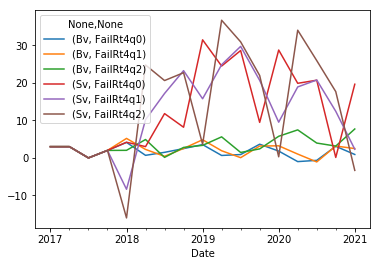

In [10]:
voldet2.swaplevel(0, 1, axis=1)[['Bv','Sv']].plot()

In [11]:
grp + "_allyr_" + rtyp + test + "_full3v_vol_"+str(ccyr[0])+"_"+str(ccyr[-1])+".csv"

'FailRt_allyr_4q_cboD_full3v_vol_2012_2018.csv'